# Create 2 merge files with all csv files and clean the NaN

In [1]:
# Import
import pandas as pd
import os, glob

# Set the path to the directory holding CSV files
DELAY_PATH = 'D:/Utilisateurs/Antoine/Documents/Unnif/5eme cours/Projet inter/CanYouCatchIt/sandbox/data/csv'

#we merge all csv files in one and change data for classification 
#this part also remove live with NaN 
all_files_csv = glob.glob(os.path.join(DELAY_PATH, "*.csv"))

all_df = []
for f in all_files_csv:
    df = pd.read_csv(f, sep=',')
    all_df.append(df)
    
#merge_3 because there are 3 classes
merged_3_df = pd.concat(all_df, ignore_index=True, sort=False)

merged_3_df=merged_3_df.drop(merged_3_df[merged_3_df.delay.isna()].index)

merged_3_df.loc[merged_3_df.delay >0,"delay"]= 1
merged_3_df.loc[merged_3_df.delay ==0,"delay"]= 0
merged_3_df.loc[merged_3_df.delay <0,"delay"]= -1

merged_3_path = DELAY_PATH + "/merged_3.csv"
merged_3_df.to_csv(merged_3_path,index=False)


merged_5_df = pd.concat(all_df, ignore_index=True, sort=False)

merged_5_df=merged_5_df.drop(merged_5_df[merged_5_df.delay.isna()].index)

merged_5_df.loc[merged_5_df.delay >=10.0,"delay"]= 10
merged_5_df.loc[(merged_5_df.delay >0) & (merged_5_df.delay <10.0),"delay"]= 1
merged_5_df.loc[merged_5_df.delay ==0,"delay"]= 0
merged_5_df.loc[(merged_5_df.delay >-10) & (merged_5_df.delay <0),"delay"]= -1
merged_5_df.loc[merged_5_df.delay <=-10,"delay"]= -10

merged_5_path = DELAY_PATH + "/merged_5.csv"
merged_5_df.to_csv(merged_5_path,index=False)


# Load the data

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedShuffleSplit
import matplotlib.pyplot as plt

def load_delay_data(path=merged_3_path):
    """
    Load the cvs file in a panda dataframe
    """
    return pd.read_csv(path)


# load the csv file
delay = load_delay_data()

# Stratifie the data with the different line
# This make sure that the representation of each stop is the same in the train set then in the overall dataset
# This stratification is not necessary is you have enough data
split = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
for train_index, test_index in split.split(delay, delay["line"]):
    strat_train_set = delay.loc[train_index]
    strat_test_set = delay.loc[test_index]


# Plot the data
## 3 classes

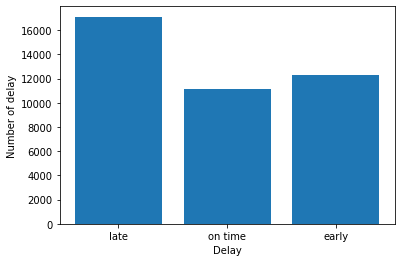

In [3]:
df_3 = pd.read_csv(merged_3_path,1,",")

delay_3 = df_3['delay'].value_counts()
delay_3_ordered = [delay_3[-1],delay_3[0],delay_3[1]]

x= ['late', 'on time', 'early']

plt.bar(x,delay_3_ordered)
plt.xlabel("Delay")
plt.ylabel("Number of delay")

plt.show()

## 5 classes

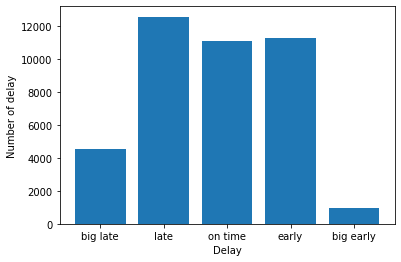

In [4]:
df_5 = pd.read_csv(merged_5_path,1,",")

delay_5 = df_5['delay'].value_counts()
delay_5_ordered = [delay_5[-10],delay_5[-1],delay_5[0],delay_5[1],delay_5[10]]

x= ['big late', 'late', 'on time', 'early','big early']

plt.bar(x,delay_5_ordered)
plt.xlabel("Delay")
plt.ylabel("Number of delay")

plt.show()

when we saw the two graph, we deicded to continue with only 3 classes

## Prepare the Data for Machine Learning Algorithms

In [5]:
delay = strat_train_set.drop("delay", axis=1) # drop labels for training set
delay_labels = strat_train_set["delay"].copy()

### Check if there is row with nan

Count the number of row with a nan value

In [6]:
sample_incomplete_rows = delay[delay.isnull().any(axis=1)].head()
len(sample_incomplete_rows.index)

0

### Check if there is attribute that are the same for every row

In [7]:
def unique_cols(df):
    a = df.to_numpy()
    return (a[0] == a).all(0)
unique= unique_cols(delay)
col = list(delay.columns)

for i in delay.columns:
    print(unique[col.index(i)],i)

True transport_type
False stop
False line
False theoretical_time
False expectedArrivalTime
False date
False direction
True date_year
True date_month
False date_weekday
False date_hour
False date_minute
False date_seconde
False temp
False humidity
False visibility
False wind
False rain


### Data Cleaning

Drop the unnecesery attribute. theoretical_time and expectedArrivalTime are droped because they are string attribute and they are not linked to the delay value. The date attribute is split into hour minute and seconds so it can be droped. The transport_type, date_year, date_month, attributes are droped because, it's the same for every row.

In [8]:
nunique = delay.apply(pd.Series.nunique)
cols_to_drop = nunique[nunique == 1].index
delay = delay.drop(cols_to_drop, axis=1)
delay = delay.drop(["theoretical_time", "expectedArrivalTime", "date"], axis=1)
delay.head()

,stop,line,direction,date_weekday,date_hour,date_minute,date_seconde,temp,humidity,visibility,wind,rain
37892,6608G,82.0,1.0,3,10,10,16,284.47,81.0,10000.0,6.2,0.0
1295,0089,44.0,0.0,0,11,5,25,291.79,77.0,10000.0,11.3,0.0
1063,0089,44.0,0.0,0,10,1,55,291.29,72.0,10000.0,10.3,0.0
19479,0089,39.0,0.0,5,14,27,5,288.82,67.0,10000.0,2.1,0.0
32081,6608G,82.0,1.0,1,19,16,26,285.46,93.0,8000.0,1.5,0.0


## Handling Text and Categorical Attributes

### Extract the non-numerical attributes

In [9]:
delay_num = delay.drop(['stop'], axis=1)

### Categorical Attributes: The stop and attributes

In [10]:
delay_cat = delay[['stop', 'line']]
delay_cat.head()

,stop,line
37892,6608G,82.0
1295,0089,44.0
1063,0089,44.0
19479,0089,39.0
32081,6608G,82.0


In [11]:
from sklearn.preprocessing import OrdinalEncoder

ordinal_encoder = OrdinalEncoder()
delay_cat_encoded = ordinal_encoder.fit_transform(delay_cat)
delay_cat_encoded[:10]

array([[1., 3.],
       [0., 1.],
       [0., 1.],
       [0., 0.],
       [1., 3.],
       [1., 2.],
       [0., 0.],
       [1., 3.],
       [1., 2.],
       [1., 3.]])

## Transformation Pipelines


In [12]:
from sklearn.preprocessing import FunctionTransformer
import numpy as np

# get the right column indices: safer than hard-coding indices

def add_extra_features(X, add_combined_time=True):
    hour_ix, minute_ix = [list(delay.columns).index(col) for col in ("date_hour", "date_minute")]
    if add_combined_time:
        hour_and_minute = X[:, hour_ix]*3600 + X[:, minute_ix]*60
        return np.c_[X, hour_and_minute]
    else:
        return np.c_[X]

attr_adder = FunctionTransformer(add_extra_features, validate=False,
                                 kw_args={"add_combined_time": True})
delay_extra_attribs = attr_adder.fit_transform(delay.values)

delay_extra_attribs = pd.DataFrame(
    delay_extra_attribs,
    columns=list(delay.columns) + ["hour_and_minute"],
    index=delay.index)
delay_extra_attribs.head()

,stop,line,direction,date_weekday,date_hour,date_minute,date_seconde,temp,humidity,visibility,wind,rain,hour_and_minute
37892,6608G,82,1,3,10,10,16,284.47,81,10000,6.2,0,36600
1295,0089,44,0,0,11,5,25,291.79,77,10000,11.3,0,39900
1063,0089,44,0,0,10,1,55,291.29,72,10000,10.3,0,36060
19479,0089,39,0,5,14,27,5,288.82,67,10000,2.1,0,52020
32081,6608G,82,1,1,19,16,26,285.46,93,8000,1.5,0,69360


In [13]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.impute import SimpleImputer

num_attribs = list(delay_num)
cat_attribs = ["stop", "line"]

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        ('attribs_adder', FunctionTransformer(add_extra_features,
                                            validate=False,
                                            kw_args={"add_combined_time": True})),
        ('std_scaler', StandardScaler())
    ])

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", OneHotEncoder(), cat_attribs),
    ])

delay_prepared = full_pipeline.fit_transform(delay)
delay_prepared

array([[ 1.67760383,  0.99827278,  0.27697762, ...,  0.        ,
         0.        ,  1.        ],
       [-0.59869751, -1.00173021, -1.30713484, ...,  1.        ,
         0.        ,  0.        ],
       [-0.59869751, -1.00173021, -1.30713484, ...,  1.        ,
         0.        ,  0.        ],
       ...,
       [ 1.67760383,  0.99827278, -0.77909735, ...,  0.        ,
         0.        ,  1.        ],
       [-0.17937885,  0.99827278,  0.8050151 , ...,  0.        ,
         1.        ,  0.        ],
       [ 1.67760383,  0.99827278,  0.27697762, ...,  0.        ,
         0.        ,  1.        ]])

## Select and train a model

### split in train and test

In [14]:
X_train, X_test, y_train, y_test = train_test_split(delay_prepared, delay_labels, test_size=0.3) # 70% training and 30% test

### Decision tree

In [15]:
from sklearn import tree

clf_tree = tree.DecisionTreeClassifier(criterion="entropy",min_samples_leaf=100)
clf_tree = clf_tree.fit(delay_prepared, delay_labels)

print(clf_tree.score(X_train,y_train))
print(clf_tree.score(X_test,y_test))

0.625755237045204
0.6208457660253113


In [16]:
from sklearn.model_selection import cross_val_score

def display_scores(scores):
    print("Scores: \t\t", scores)
    print("Mean: \t\t\t", scores.mean())
    print("Standard deviation: \t", scores.std())

In [17]:
scores = cross_val_score(clf_tree, delay_prepared, delay_labels, scoring="accuracy", cv=10)
display_scores(scores)

Scores: 		 [0.59969136 0.61790123 0.60277778 0.60123457 0.61296296 0.60864198
 0.61975309 0.6127239  0.60901791 0.60284126]
Mean: 			 0.6087546038935786
Standard deviation: 	 0.006689981813420387


### Random Forest

In [18]:
from sklearn.utils import class_weight
#compute the weight of a class
def compute_class_weight_dictionary(y):
    # helper for returning a dictionary instead of an array
    classes = np.unique(y)
    weight = class_weight.compute_class_weight("balanced", classes, y)
    class_weight_dict = dict(zip(classes, weight))
    return class_weight_dict

class_weight=compute_class_weight_dictionary(delay_labels)

In [19]:
from sklearn.ensemble import RandomForestClassifier

clf=RandomForestClassifier(n_estimators=100,criterion="entropy",bootstrap=True,min_samples_leaf=300,class_weight=class_weight)
clf.fit(X_train,y_train)
print("class_weight")
print("trained score: ", clf.score(X_train,y_train))
print("test score: ", clf.score(X_test,y_test))
scores = cross_val_score(clf, delay_prepared, delay_labels, scoring="accuracy", cv=10)
display_scores(scores)

clf=RandomForestClassifier(n_estimators=100,criterion="entropy",bootstrap=True,min_samples_leaf=100)
clf.fit(X_train,y_train)
print("min leaf = 100")
print("trained score: ", clf.score(X_train,y_train))
print("test score: ", clf.score(X_test,y_test))
scores = cross_val_score(clf, delay_prepared, delay_labels, scoring="accuracy", cv=10)
display_scores(scores)
    


class_weight
trained score:  0.5487982359426682
test score:  0.5412079432040333
Scores: 		 [0.56049383 0.55092593 0.55246914 0.56512346 0.56388889 0.56481481
 0.57160494 0.57504632 0.56331069 0.54756022]
Mean: 			 0.5615238220514109
Standard deviation: 	 0.008410750053588578
min leaf = 100
trained score:  0.6153914002205072
test score:  0.6064409918715917
Scores: 		 [0.60987654 0.61450617 0.61265432 0.60895062 0.61203704 0.61574074
 0.61635802 0.61519456 0.61519456 0.60098826]
Mean: 			 0.6121500850242871
Standard deviation: 	 0.004415283525533786


### KNN

In [20]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=50,leaf_size=300)
knn.fit(X_train, y_train)

print("trained score: ", knn.score(X_train,y_train))
print("test score: ", knn.score(X_test,y_test))

scores = cross_val_score(knn, delay_prepared, delay_labels, scoring="accuracy", cv=10)
display_scores(scores)

trained score:  0.595678059536935
test score:  0.571252186438934
Scores: 		 [0.575      0.58981481 0.57283951 0.56820988 0.57407407 0.59074074
 0.5808642  0.59079679 0.58122298 0.57689932]
Mean: 			 0.580046229573201
Standard deviation: 	 0.00768437615163762


## take a look on grid search 
### grid search for random forest 

In [21]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 72 (2x3x4x3) combinations of hyperparameters    
    {'bootstrap': [False,True], 'n_estimators': [5,10,100], 'max_features': [2, 3, 4,8],'min_samples_leaf': [100,200,500]},
  ]

forest_class = RandomForestClassifier(random_state=42)
# train across 5 folds, that's a total of (72)*5=360 rounds of training 
grid_search = GridSearchCV(forest_class, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{

In [22]:
grid_search.best_params_

{'bootstrap': False,
 'max_features': 8,
 'min_samples_leaf': 100,
 'n_estimators': 100}

In [23]:
cvres = grid_search.cv_results_
for mean_train_score, mean_score, params in zip(cvres["mean_train_score"],cvres["mean_test_score"], cvres["params"]):
    print(mean_train_score,mean_score, params)

0.5854710613136976 0.5749212817188368 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 5}
0.5949481218838673 0.5832561585478793 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 10}
0.6138944942168821 0.6006976600605051 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 100, 'n_estimators': 100}
0.5729378741129835 0.564394640982898 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 200, 'n_estimators': 5}
0.5718496372110855 0.5664937951472495 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 200, 'n_estimators': 10}
0.5898700437457994 0.581311353954436 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 200, 'n_estimators': 100}
0.5420295404547482 0.5409643761190344 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 500, 'n_estimators': 5}
0.5419059907548212 0.5411495956041242 {'bootstrap': False, 'max_features': 2, 'min_samples_leaf': 500, 'n_estimators': 10}
0.5634916842908851 

In [24]:
clf=RandomForestClassifier(n_estimators=100,criterion="entropy",bootstrap=False,min_samples_leaf=100,max_features=8)
clf.fit(X_train,y_train)
print("class_weight")
print("trained score: ", clf.score(X_train,y_train))
print("test score: ", clf.score(X_test,y_test))
scores = cross_val_score(clf, delay_prepared, delay_labels, scoring="accuracy", cv=10)
display_scores(scores)

class_weight
trained score:  0.6302535832414553
test score:  0.6147751826319581
Scores: 		 [0.61388889 0.62067901 0.62160494 0.6212963  0.62438272 0.61975309
 0.62962963 0.62600371 0.62260655 0.60592959]
Mean: 			 0.6205774407308275
Standard deviation: 	 0.00625733667423197


if we take a depper look on the scores, we can see that it is always with the min_sample_leaf = 100 that we have better results
take let's try this with other hyperparameters

In [35]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 64 (2x4x2x4) combinations of hyperparameters    
    {'bootstrap': [False,True], 'max_features': [2, 3, 4,8],'criterion' : ["entropy","gini"],'min_samples_leaf': [10,30,50,100]},
  ]

forest_class = RandomForestClassifier(random_state=42,n_estimators=10)
# train across 5 folds, that's a total of (64)*5=320 rounds of training 
grid_search = GridSearchCV(forest_class, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'boo

In [36]:
grid_search.best_params_

{'bootstrap': False,
 'criterion': 'gini',
 'max_features': 8,
 'min_samples_leaf': 10}

In [37]:
cvres = grid_search.cv_results_
for mean_train_score, mean_score, params in zip(cvres["mean_train_score"],cvres["mean_test_score"], cvres["params"]):
    print(mean_train_score,mean_score, params)

0.7653113329624628 0.6536704327961969 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 10}
0.657552280655059 0.6160708773229611 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 30}
0.6293989606925579 0.6068099030684695 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 50}
0.5907498484515542 0.5799530777304439 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 2, 'min_samples_leaf': 100}
0.772149106874612 0.6623757485954189 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 10}
0.6664892046844536 0.6281101438538 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 30}
0.6402496614497836 0.617521763289498 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 50}
0.6155615610698395 0.6016546274001359 {'bootstrap': False, 'criterion': 'entropy', 'max_features': 3, 'min_samples_leaf': 1

we can see that if we choose 10 on the min_sample_leaf, we start to have an overfit it's a small overfit wich allows to have a better scores on the test set but it is not the right things to do, according to me, we have to choose between 30 and 50, 30 seem to be the best. we wan also see that gini is the best we can remove it from the grid, it is the default criterion 

In [45]:
from sklearn.model_selection import GridSearchCV

param_grid = [
    # try 6 (2x3) combinations of hyperparameters    
    {'bootstrap': [False,True], 'max_features': [4,8,"auto"]},
  ]

forest_class = RandomForestClassifier(random_state=42,n_estimators=10,min_samples_leaf=30)
# train across 5 folds, that's a total of (6)*5=30 rounds of training 
grid_search = GridSearchCV(forest_class, param_grid, cv=5, scoring='accuracy', return_train_score=True)
grid_search.fit(delay_prepared, delay_labels)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=30,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=10, n_jobs=None,
                                              oob_score=False, random_state=42,
                                              verbose=0, warm_start=False),
             iid='warn', n_jobs=None,
             param_grid=[{'bo

In [46]:
grid_search.best_params_

{'bootstrap': False, 'max_features': 8}

In [47]:
cvres = grid_search.cv_results_
for mean_train_score, mean_score, params in zip(cvres["mean_train_score"],cvres["mean_test_score"], cvres["params"]):
    print(mean_train_score,mean_score, params)

0.6782428886705565 0.634778045317034 {'bootstrap': False, 'max_features': 4}
0.6892788710941886 0.6411063777242699 {'bootstrap': False, 'max_features': 8}
0.6782428886705565 0.634778045317034 {'bootstrap': False, 'max_features': 'auto'}
0.652080691159783 0.6228313885287399 {'bootstrap': True, 'max_features': 4}
0.6629082193499262 0.6301784281039698 {'bootstrap': True, 'max_features': 8}
0.652080691159783 0.6228313885287399 {'bootstrap': True, 'max_features': 'auto'}


the choice belong to us now, I would say that i agree with the best_params_ even if the train scores is 5% higher than the test, it is negligible

if we take a look on the scores, we can see that some of them even if it's a good score, it comes from an overfitting so we have to look deeper and we can see that the best score which does not comme from an overfit is 
max_depth = 10 and max_features = 8 and not the one that is given by the best_params. 

In [54]:
full_pipeline_with_predictor = Pipeline([
        ("preparation", full_pipeline),
        ("classifier", RandomForestClassifier(random_state=42,n_estimators=10,min_samples_leaf=30,bootstrap=False,max_features=8))
    ])
full_pipeline_with_predictor.fit(delay, delay_labels)

test_set = strat_test_set.drop("delay", axis=1) # drop labels for test set
test_set_labels = strat_test_set["delay"].copy()
print(test_set_labels[500:510].array)
print(list(full_pipeline_with_predictor.predict(test_set[500:510])))

<PandasArray>
[0.0, 0.0, -1.0, -1.0, -1.0, 1.0, -1.0, -1.0, 0.0, 1.0]
Length: 10, dtype: float64
[0.0, 0.0, -1.0, -1.0, -1.0, 1.0, -1.0, 1.0, 1.0, -1.0]


we can see that 7 predictions on 10 are correct. With 64% of right answer, it seem to correspond 

### Save the model 

In [57]:
import joblib

save_path = 'D:/Utilisateurs/Antoine/Documents/Unnif/5eme cours/Projet inter/CanYouCatchIt/sandbox/classification/models/forest_model.pkl'

forest_model = full_pipeline_with_predictor
joblib.dump(forest_model, save_path) # save

# my_model_loaded = joblib.load("my_model.pkl") # load

['D:/Utilisateurs/Antoine/Documents/Unnif/5eme cours/Projet inter/CanYouCatchIt/sandbox/classification/models/forest_model.pkl']